In [1]:
cd /content/drive/MyDrive/kaggle_study/05-finance_style_visualization

/content/drive/MyDrive/kaggle_study/05-finance_style_visualization


In [2]:
!unzip data08.zip

Archive:  data08.zip
  inflating: KCB 대회 약관.pdf  
  inflating: credit_card_data.csv    
  inflating: jeju_financial_life_data.csv  


## [0] Module Import

In [2]:
# eli5 library download
!pip install eli5

In [3]:
# shap library download
!pip install shap

In [4]:
import pandas as pd # Analysis
import numpy as np # Analysis
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

### About Warning Message 
# import warnings 
# warnings.filterwarnings('ignore')

%matplotlib inline
color = sns.color_palette()

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import eli5
from eli5.sklearn import PermutationImportance

import shap

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### ***matplotlib***, Setting
*matplotlib*의 *rcParams* 설정을 통해, 차트의 크기와 선의 색, 두께 등의 기본 값을 설정할 수 있다.

In [7]:
# 그래프에서의 배경색
plt.rcParams["figure.facecolor"] = 'w' # white
# 그래프에서 한글이 지원되는 글씨체로 변경
# 나눔고딕체가 설치되지 않음
# plt.rcParams["font.family"] = 'NanumBarunGothic'
# 그래프에서 마이너스 기호가 깨지지 않게 표시되도록
plt.rcParams['axes.unicode_minus'] = False

#### 한글 지원 글씨체 설치
한글이 지원되는 글씨체가 없어 한글이 깨지는 현상 발생

따라서 한글이 지원되는 글씨체를 설치해주어야함

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

f = [f.name for f in fm.fontManager.ttflist]
f[:10]
# 한글 지원되는 글씨체가 설치되어있지 않음

['DejaVu Sans Mono',
 'DejaVu Sans',
 'DejaVu Sans',
 'cmex10',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'DejaVu Sans Mono']

아래 코드를 실행하면 matlablib 디렉토리에 나눔고딕체 설치

[실행 -> 런타임 다시연결 -> 실행] 과정을 거치면 글씨체 설치 완료 !

In [6]:
!apt -qq -y install fonts-nanum > /dev/null
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

## [1] Data Load & Data Processing

* pop_cd : 
* year : 연도
* month : 월
* avg_score : 신용 점수
* avg_rate : 신용 등급
* city : 지역
* sex : 성별
* ages : 나이
* population
* num_opencard : 개설된 카드의 수
* num_usedcard : 사용하는 카드의 수
* monthly_card_spend : 총 카드 승인 금액
* monthly_lc :  대출 약정 금액
* monthly_loan : 대출 금액
* monthly_bk_loan : 은행 대출
* monthly_cd_loan :
* monthly_installments_loan : 할부 금융 대출
* monthly_insurance_loan : 
* monthly_sbk_loan : 저축은행 대출
* loan_commitment :
* inst_rep_loanb :
* ls_rep_loanb :
* credit_loan : 
* mortgage_loan : 담보대출
* credit_card_payment : 신용카드 사용 금액
* credit_card_installments_payment : 신용카드 할부 금액

In [8]:
train = pd.read_csv("credit_card_data.csv")
train

,pop_cd,year,month,avg_score,avg_rat,city,sex,ages,population,num_opencard,num_usecard,monthly_card_spend,monthly_lc,monthly_loan,monthly_bk_loan,monthly_cd_loan,monthly_installments_loan,monthly_insurance_loan,monthly_sbk_loan,loan_commitment,inst_rep_loanb,ls_rep_loanb,credit_loan,mortgage_loan,credit_card_payment,credit_card_installments_payment
0,L011,2016,1,812,2,서울,NaN,10대,55000,1.44,1.13,70000,92630000,87350000,85790000,0,0,0,0,1120000,8210000,78020000,92170000,87260000,0,0
1,L011,2016,2,773,4,서울,NaN,10대,380000,1.71,0.96,170000,31140000,28910000,25850000,190000,510000,220000,1020000,680000,4660000,23300000,8260000,42410000,4000,1000
2,L011,2016,3,771,4,서울,NaN,10대,387000,1.75,0.95,190000,30230000,28180000,25110000,170000,490000,210000,1140000,640000,4370000,22930000,8300000,41710000,3000,1000
3,L011,2016,4,770,4,서울,NaN,10대,412000,1.76,0.92,200000,30430000,27710000,24630000,190000,510000,240000,1340000,510000,4770000,22160000,9460000,41040000,4000,1000
4,L011,2016,5,771,4,서울,NaN,10대,414000,1.75,0.94,170000,31210000,27620000,24390000,210000,490000,340000,1490000,640000,4740000,21960000,9660000,40850000,3000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,Y95,2017,8,819,3,NaN,여자,90대,232000,0.11,0.03,90000,100520000,86580000,76570000,30000,40000,840000,450000,7290000,21340000,57900000,26130000,98590000,36000,11000
3884,Y95,2017,9,819,3,NaN,여자,90대,235000,0.11,0.03,90000,100580000,86780000,76890000,30000,400000,840000,430000,7110000,21710000,57910000,30360000,99110000,36000,8000
3885,Y95,2017,10,819,3,NaN,여자,90대,239000,0.11,0.03,90000,100380000,86110000,75690000,40000,1190000,790000,450000,6950000,21720000,57370000,32470000,98340000,36000,12000
3886,Y95,2017,11,819,3,NaN,여자,90대,243000,0.11,0.03,90000,100370000,85920000,75160000,30000,1230000,860000,580000,6850000,21700000,57300000,33480000,97520000,32000,11000


### Missing Data & Data Type
데이터 처리에 대해서는 데이터 설명을 참고

In [9]:
# 지역별 통계는 전국에 대한 통계이므로, city의 결측치 -> '전국'
train['city'] = train['city'].fillna('전국')

# 성별 통계는 남여 전체에 대한 통계이므로, sex의 결측치 -> '전체'
train['sex'] = train['sex'].fillna('전체')

# 나이별 통계는 연산의 용이성을 위해 숫자로 변환
train['ages'] = train['ages'].apply(lambda x:int(x[:-1])).astype(float)

# year & month 열은 datetime 형식으로 새로운 열 year_month 로 병합
train['year_month'] = pd.to_datetime((train.year*100+train.month).apply(str),format='%Y%m')

# year, month 열 drop
train.drop(['year','month'], axis=1, inplace=True)

# 맨 마지막 열로 추가한 year_month 열을 두번째 열로 순서 변경
train = train[[train.columns[0],'year_month']+list(train.columns[1:-1])]

In [10]:
# 변경사항 확인
train

,pop_cd,year_month,avg_score,avg_rat,city,sex,ages,population,num_opencard,num_usecard,monthly_card_spend,monthly_lc,monthly_loan,monthly_bk_loan,monthly_cd_loan,monthly_installments_loan,monthly_insurance_loan,monthly_sbk_loan,loan_commitment,inst_rep_loanb,ls_rep_loanb,credit_loan,mortgage_loan,credit_card_payment,credit_card_installments_payment
0,L011,2016-01-01,812,2,서울,전체,10.0,55000,1.44,1.13,70000,92630000,87350000,85790000,0,0,0,0,1120000,8210000,78020000,92170000,87260000,0,0
1,L011,2016-02-01,773,4,서울,전체,10.0,380000,1.71,0.96,170000,31140000,28910000,25850000,190000,510000,220000,1020000,680000,4660000,23300000,8260000,42410000,4000,1000
2,L011,2016-03-01,771,4,서울,전체,10.0,387000,1.75,0.95,190000,30230000,28180000,25110000,170000,490000,210000,1140000,640000,4370000,22930000,8300000,41710000,3000,1000
3,L011,2016-04-01,770,4,서울,전체,10.0,412000,1.76,0.92,200000,30430000,27710000,24630000,190000,510000,240000,1340000,510000,4770000,22160000,9460000,41040000,4000,1000
4,L011,2016-05-01,771,4,서울,전체,10.0,414000,1.75,0.94,170000,31210000,27620000,24390000,210000,490000,340000,1490000,640000,4740000,21960000,9660000,40850000,3000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,Y95,2017-08-01,819,3,전국,여자,90.0,232000,0.11,0.03,90000,100520000,86580000,76570000,30000,40000,840000,450000,7290000,21340000,57900000,26130000,98590000,36000,11000
3884,Y95,2017-09-01,819,3,전국,여자,90.0,235000,0.11,0.03,90000,100580000,86780000,76890000,30000,400000,840000,430000,7110000,21710000,57910000,30360000,99110000,36000,8000
3885,Y95,2017-10-01,819,3,전국,여자,90.0,239000,0.11,0.03,90000,100380000,86110000,75690000,40000,1190000,790000,450000,6950000,21720000,57370000,32470000,98340000,36000,12000
3886,Y95,2017-11-01,819,3,전국,여자,90.0,243000,0.11,0.03,90000,100370000,85920000,75160000,30000,1230000,860000,580000,6850000,21700000,57300000,33480000,97520000,32000,11000


### 유니트 개수에 대한 변수의 다양성
각 column에 대한 unique 값의 개수 시각화   
-> 대표적인 시각화 툴인 seaborn 중 [barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) (막대그래프) 을 사용하여 시각화

In [11]:
train_unique = []
for i in train.columns.values:
    train_unique.append(len(train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = list(train.columns)
unique_train['Unique_value'] = train_unique

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


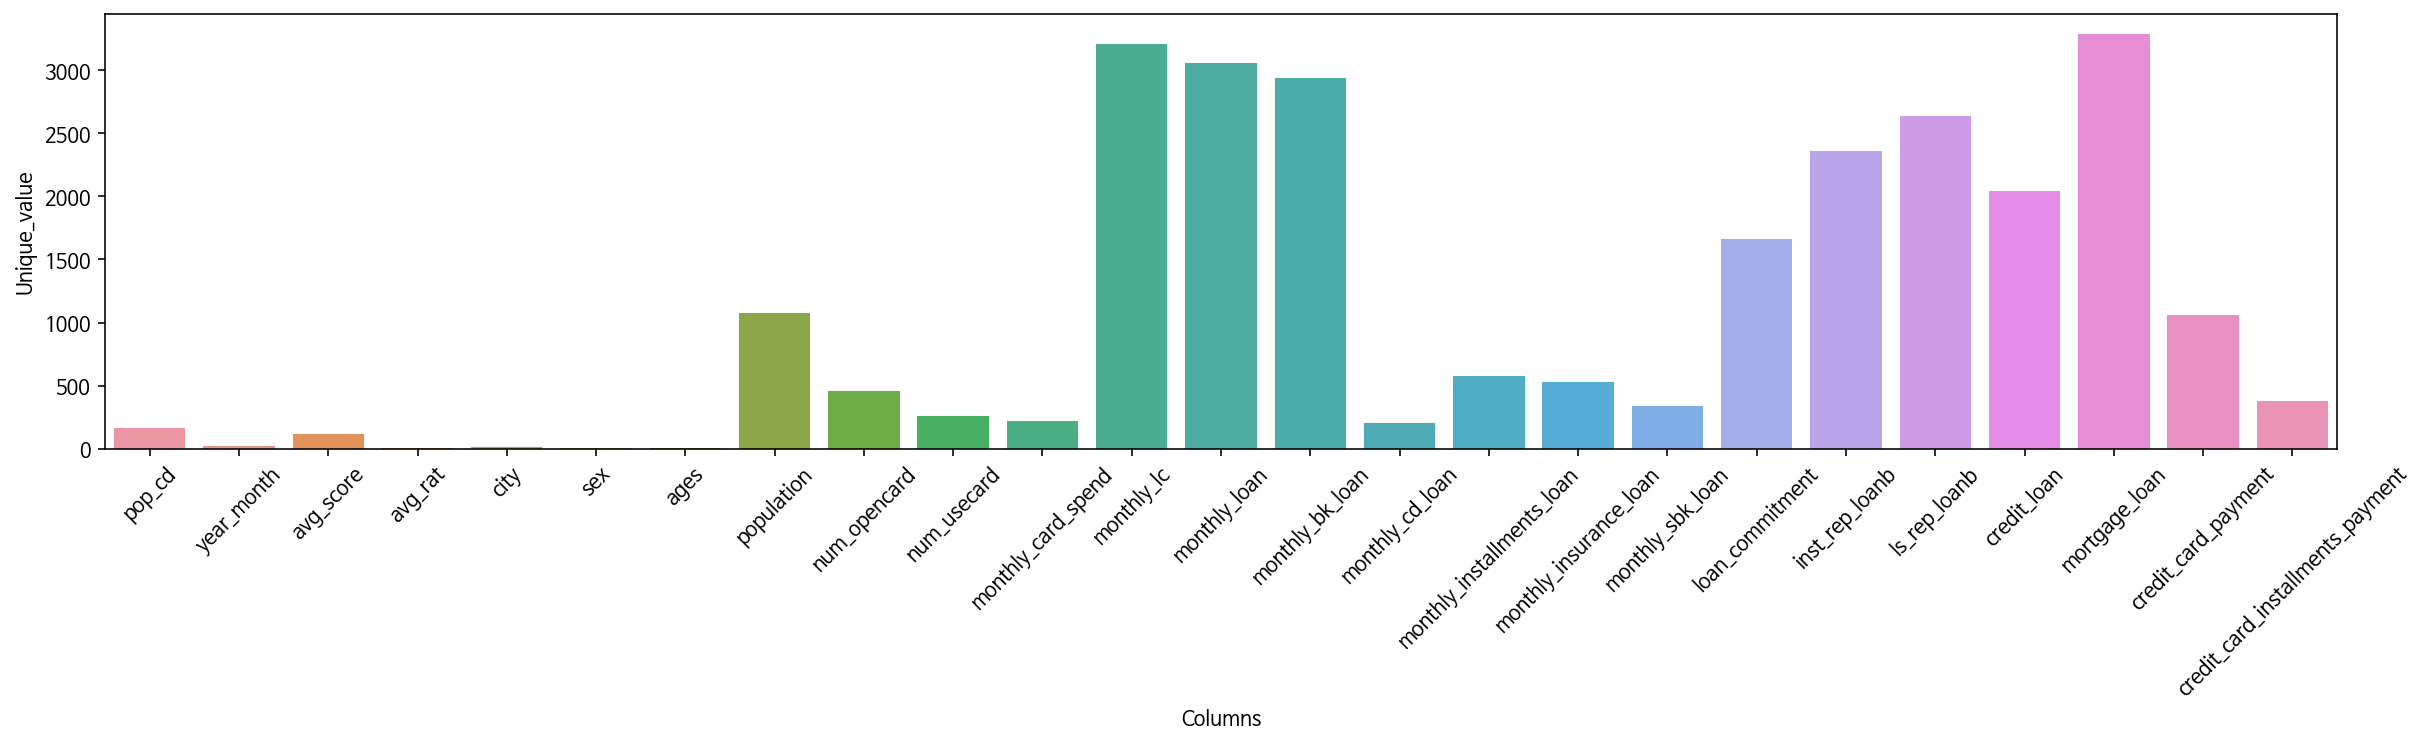

In [12]:
plt.figure(figsize=(20,4))

# seaborn.barplot을 이용하여 시각화 (x축, y축)
sns.barplot(unique_train['Columns'], unique_train['Unique_value'])

# 그래프 축 간격을 표시하는 눈금 xticks()
xt = plt.xticks()
_ = plt.xticks(xt[0], train.columns, rotation=45)

## [2] 상관관계 분석
* 양의 상관관계가 클수록 비례
* 음의 상관관계가 클수록 반비례
* 0에 가까울수록 낮은 상관관계


참고, 상관계수를 시각화 할 때에는 한쪽 삼각형만 나타내는 것이 깔끔

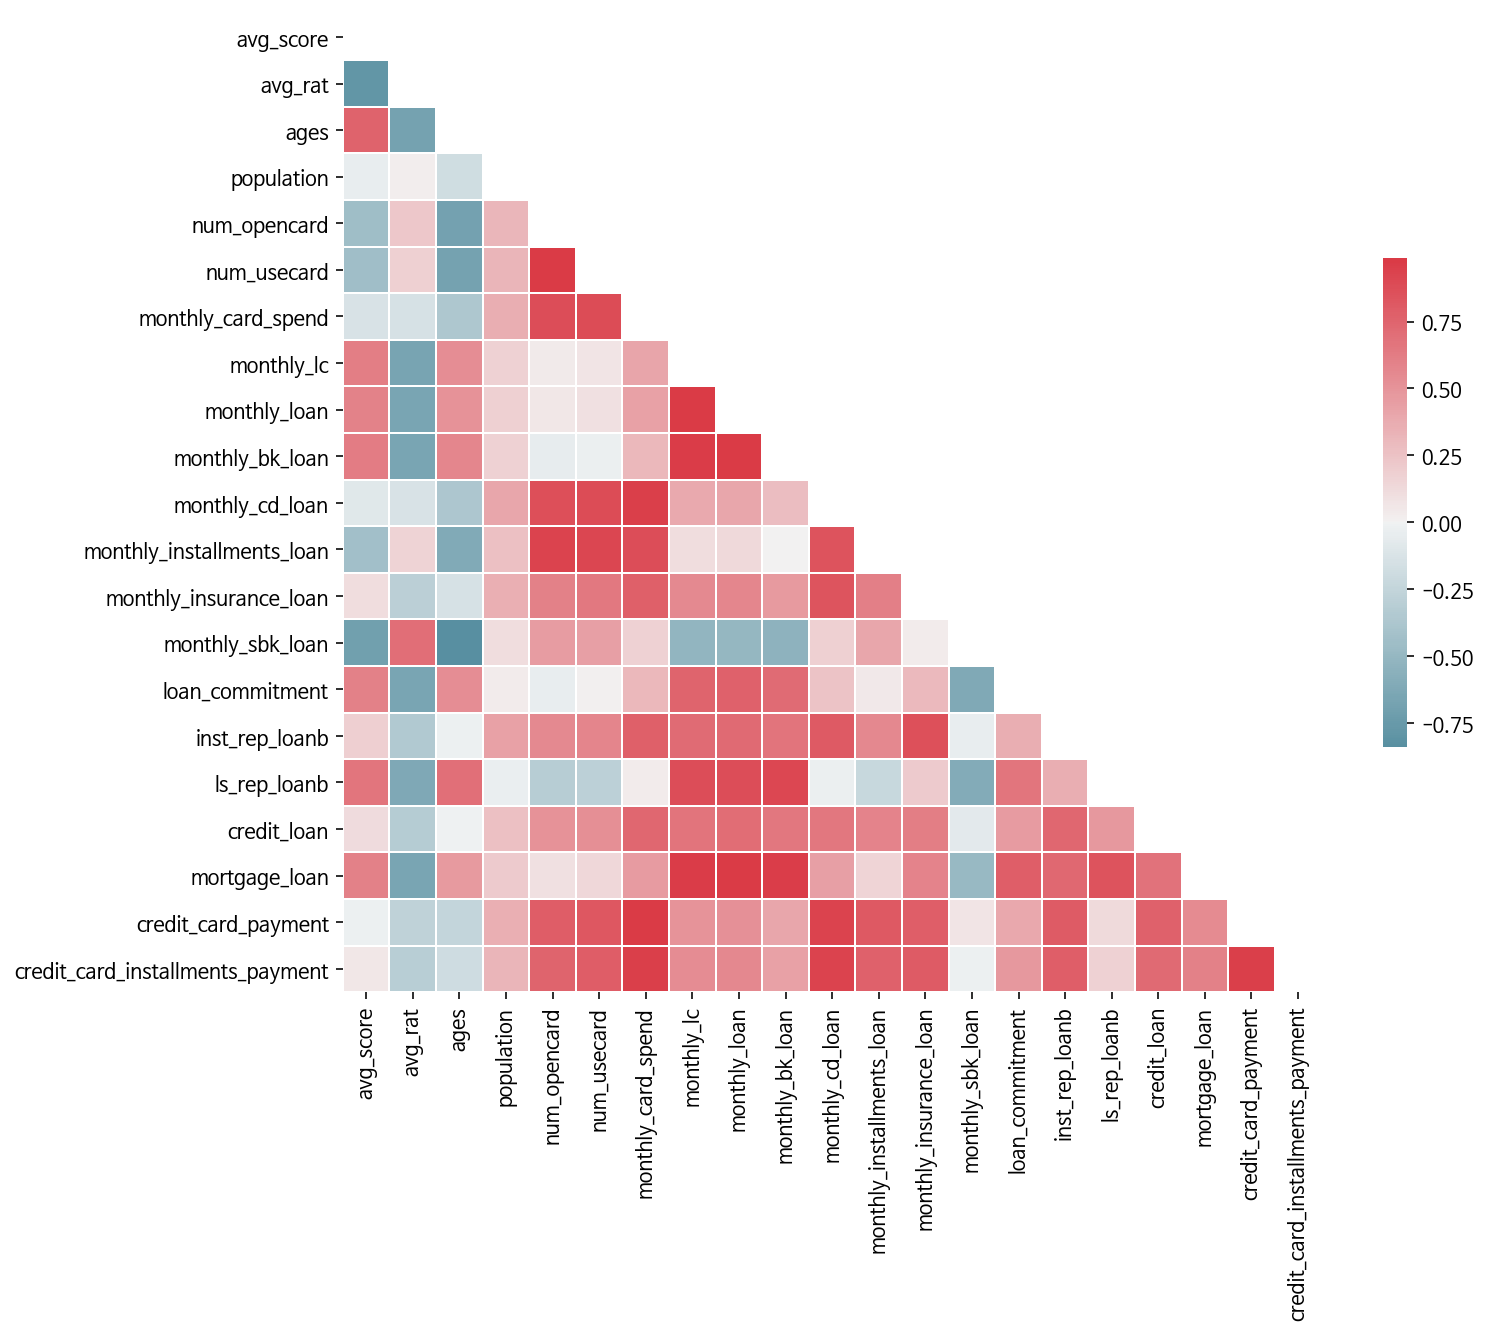

In [13]:
# column 간의 상관관계 분석 DataFrame.corr() 
corr = train.corr()

# 삼각형 마스크 만들기 (위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [17]:
corr = train.corr().unstack().sort_values(ascending=False).drop_duplicates()
corr.drop(corr.index[0],inplace=True)
display(corr.head())
display(corr.tail())

monthly_loan         monthly_lc            0.986415
credit_card_payment  monthly_card_spend    0.985854
mortgage_loan        monthly_loan          0.985699
num_usecard          num_opencard          0.983744
monthly_loan         monthly_bk_loan       0.980280
dtype: float64

ages              num_usecard        -0.679487
num_opencard      ages               -0.688015
avg_score         monthly_sbk_loan   -0.701963
avg_rat           avg_score          -0.786341
monthly_sbk_loan  ages               -0.841758
dtype: float64

In [18]:
corr

monthly_loan         monthly_lc            0.986415
credit_card_payment  monthly_card_spend    0.985854
mortgage_loan        monthly_loan          0.985699
num_usecard          num_opencard          0.983744
monthly_loan         monthly_bk_loan       0.980280
                                             ...   
ages                 num_usecard          -0.679487
num_opencard         ages                 -0.688015
avg_score            monthly_sbk_loan     -0.701963
avg_rat              avg_score            -0.786341
monthly_sbk_loan     ages                 -0.841758
Length: 210, dtype: float64

상관계수가 가장 높은 5쌍은 아래와 같다

* monthly_loan & monthly_lc:   
대출금액은 대출약정금액에 포함되므로 상관관계가 1에 가깝다는 것은 대출약정이 많을수록 대출 발생도 많이 했으므로, 마이너스 통장과 같은 대출 발생 금액은 상대적으로 적다고 할 수 있다.
* credit_card_payment & monthly_card_spend:   
신용카드 사용 금액은 총 카드 승인 금액에 포함되므로 상관관계가 1에 가깝다는 것은 체크카드 사용량이 적다는 것을 알 수 있다.
* mortgage_loan & monthly_loan:   
담보대출은 대출금액에 포함되므로 상관관계가 1에 가깝다는 것은 대출이 많을수록 담보대출도 많아지므로 대출의 상당수가 담보대출이라고 생각할 수 있다.
* num_usecard & num_opencard:   
개설한 카드 수와 사용 카드 수가 비례하므로 유휴 카드가 많지 않다고 해석할 수 있다.
* monthly_loan & monthly_bk_loan:   
은행대출은 대출금액에 포함되므로 상관관계가 1에 가깝다는 것은 대출의 상당수가 은행대출이라는 것을 알 수 있다.

상관계수가 가장 낮은 5쌍은 아래와 같다

* ages & num_usecard:   
상관관계에 따르면 나이가 높을수록 사용하는 카드의 수가 적다. 고령으로 갈수록 필요한 카드만 사용한다고 볼 수 있다.
* num_opencard & ages:   
나이와 사용카드의 관계와 동일하게 해석 가능하다
* avg_score & monthly_sbk_loan:   
저축은행 대출이 낮을수록 신용점수가 높다.
* avg_rat & avg_score:   
신용점수가 높을수록 높은 등급을 받는 것은 당연하지만, 등급이 높을수록 숫자가 낮아 음의 상관관계를 가진다.
* monthly_sbk_loan & ages:   
나이가 낮을수록 저축은행 대출이 높다.

#### [cf] 함수 알아보기
unstack: 계층 바꾸기   
sort_values(ascending=False): 내림차순   
drop_duplicates(): 중복값 하나만 남기고 제거

In [41]:
# corr = train.corr().unstack().sort_values(ascending=False).drop_duplicates()
train.corr().unstack()

avg_score                         avg_score                           1.000000
                                  avg_rat                            -0.786341
                                  ages                                0.763172
                                  population                         -0.044695
                                  num_opencard                       -0.446069
                                                                        ...   
credit_card_installments_payment  ls_rep_loanb                        0.174036
                                  credit_loan                         0.723537
                                  mortgage_loan                       0.601213
                                  credit_card_payment                 0.956857
                                  credit_card_installments_payment    1.000000
Length: 441, dtype: float64

In [42]:
# corr = train.corr().unstack().sort_values(ascending=False).drop_duplicates()
train.corr().unstack().sort_values(ascending=False)

credit_card_installments_payment  credit_card_installments_payment    1.000000
monthly_bk_loan                   monthly_bk_loan                     1.000000
credit_loan                       credit_loan                         1.000000
ls_rep_loanb                      ls_rep_loanb                        1.000000
inst_rep_loanb                    inst_rep_loanb                      1.000000
                                                                        ...   
monthly_sbk_loan                  avg_score                          -0.701963
avg_rat                           avg_score                          -0.786341
avg_score                         avg_rat                            -0.786341
monthly_sbk_loan                  ages                               -0.841758
ages                              monthly_sbk_loan                   -0.841758
Length: 441, dtype: float64

In [43]:
# corr = train.corr().unstack().sort_values(ascending=False).drop_duplicates()
train.corr().unstack().sort_values(ascending=False).drop_duplicates()

credit_card_installments_payment  credit_card_installments_payment    1.000000
monthly_loan                      monthly_lc                          0.986415
credit_card_payment               monthly_card_spend                  0.985854
mortgage_loan                     monthly_loan                        0.985699
num_usecard                       num_opencard                        0.983744
                                                                        ...   
ages                              num_usecard                        -0.679487
num_opencard                      ages                               -0.688015
avg_score                         monthly_sbk_loan                   -0.701963
avg_rat                           avg_score                          -0.786341
monthly_sbk_loan                  ages                               -0.841758
Length: 211, dtype: float64

In [44]:
# corr.drop(corr.index[0],inplace=True)
corr

monthly_loan         monthly_lc            0.986415
credit_card_payment  monthly_card_spend    0.985854
mortgage_loan        monthly_loan          0.985699
num_usecard          num_opencard          0.983744
monthly_loan         monthly_bk_loan       0.980280
                                             ...   
ages                 num_usecard          -0.679487
num_opencard         ages                 -0.688015
avg_score            monthly_sbk_loan     -0.701963
avg_rat              avg_score            -0.786341
monthly_sbk_loan     ages                 -0.841758
Length: 210, dtype: float64

### [2-1] 연령별 상관관계 분석
전체 데이터의 상관관계가 연령, 지역별로도 적용되는지 확인하기 위해 데이터를 그룹에 따라 모아서 평균 신용점수(avg_score)에 대해서만 상관관계를 분석해보았다.

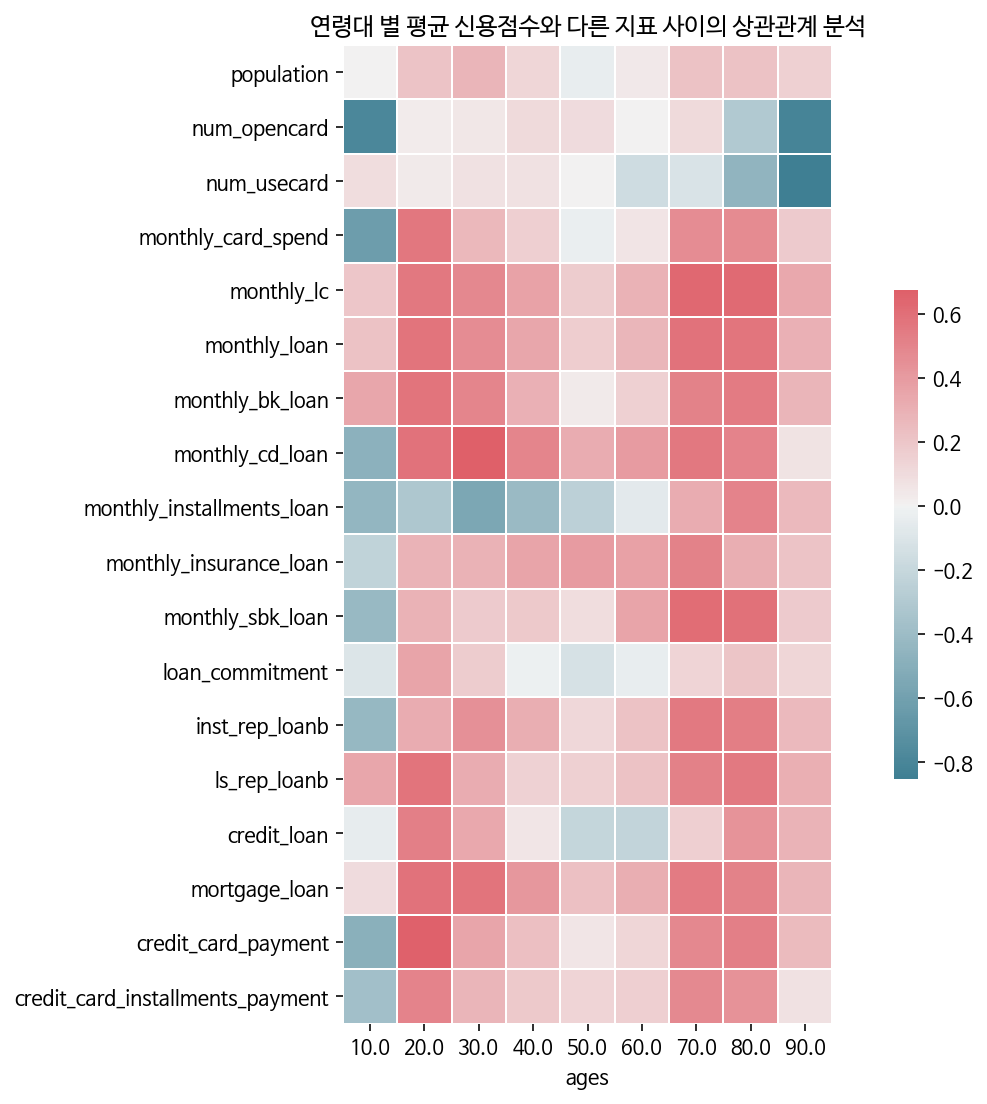

In [15]:
corr = train[train.columns[1:]].groupby('ages').corr()['avg_score'].fillna(0).unstack()
mask = np.zeros_like(corr, dtype=np.bool)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.T[2:],  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('연령대 별 평균 신용점수와 다른 지표 사이의 상관관계 분석')
plt.show()

### [2-2] 지역별 상관관계 분석

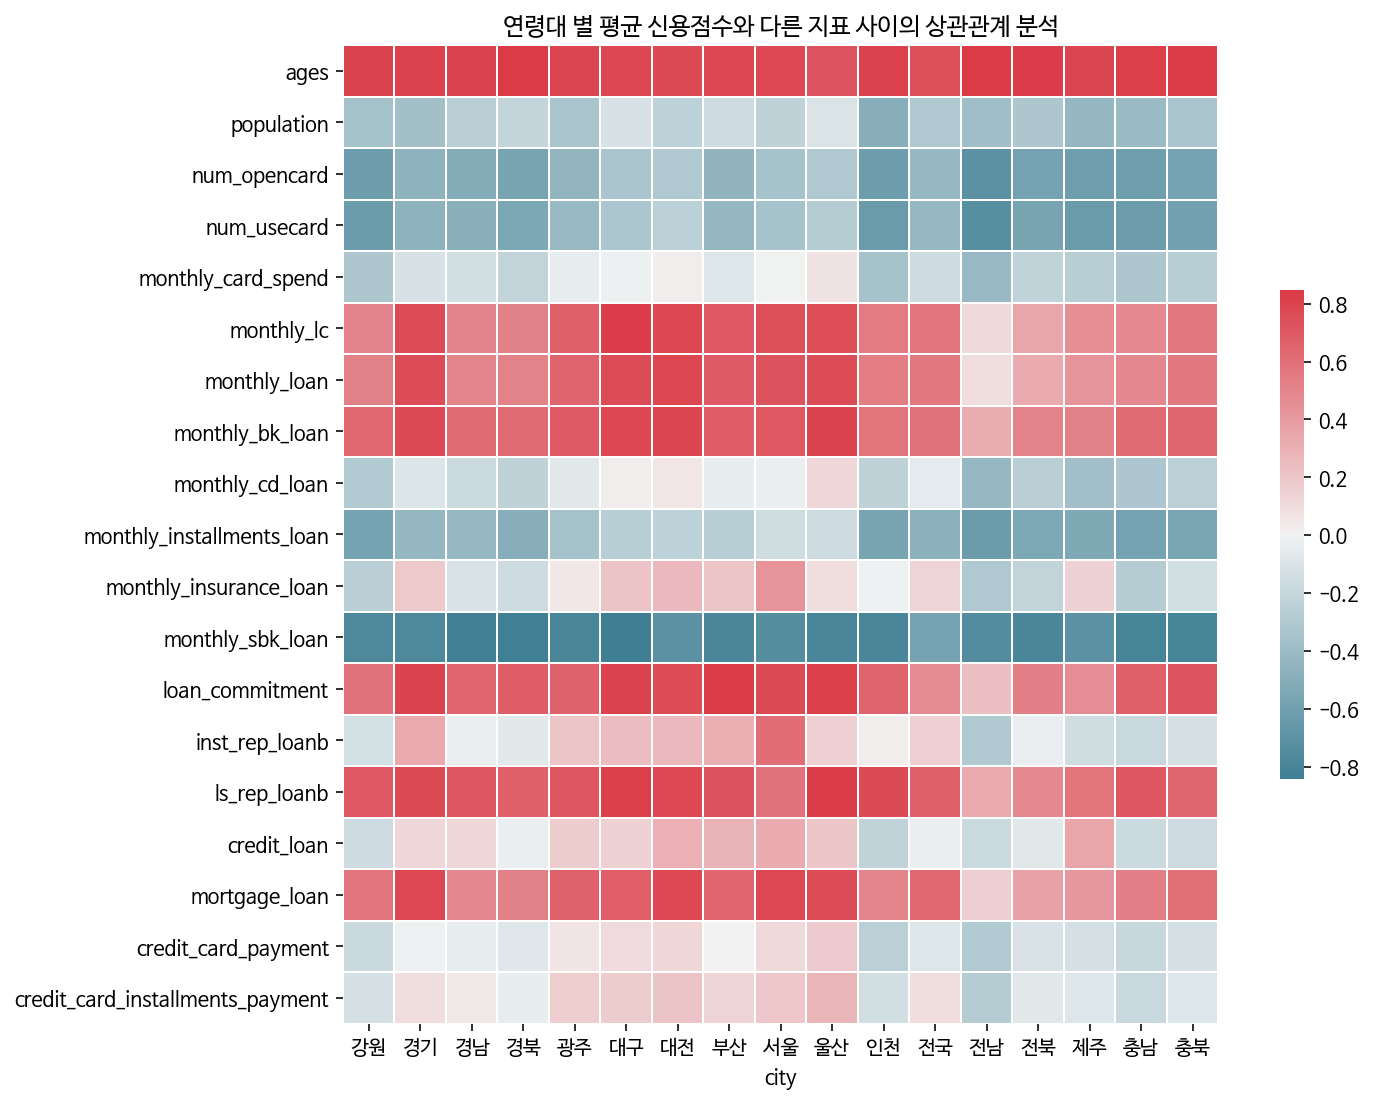

In [19]:
corr = train[train.columns[1:]].groupby('city').corr()['avg_score'].fillna(0).unstack()
mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.T[2:],  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('연령대 별 평균 신용점수와 다른 지표 사이의 상관관계 분석')
plt.show()

=> 위 분석에 따르면 **신용점수**와의 상관관계는 지역에 따라서는 큰 편차가 없지만 **연령에 따라서는 편차가 큰 것**으로 보인다.




## [3] 학습 : 신용점수 예측모델 학습
---
신용점수를 예측하는 모델을 학습하여 신용도에 영향을 많이 주는 요소를 분석한다.

* 예측 목표: 'avg_score'
* 학습에 사용되는 요소: 'num_opencard', 'num_usecard', 'monthly_card_spend', 'monthly_lc', 'monthly_loan', 'monthly_bk_loan', 'monthly_cd_loan', 'monthly_installments_loan', 'monthly_insurance_loan', 'monthly_sbk_loan', 'loan_commitment', 'inst_rep_loanb', 'ls_rep_loanb', 'credit_loan', 'mortgage_loan', 'credit_card_payment', 'credit_card_installments_payment'
* 학습에서 제외된 요소: 'pop_cd', 'city', 'ages', 'sex', 'year_month', 'population', 'avg_rat'

### [0] 변수 중요도 분석
* Feature Importance: 해당 요소가 데이터를 학습 목적에 맞게 얼마나 잘 나누는지
* Permutation Importance: 해당 요소의 값만 다른 샘플과 임의로 바꾸었을 때 예측 성능이 감소하는 정도

In [20]:
from sklearn.model_selection import train_test_split

target = 'avg_score'
cols_to_drop = ['pop_cd','city','ages', 'sex', 'year_month', 'population','avg_rat', target]
cols_to_fit = [col for col in train.columns if col not in cols_to_drop]
train_split, val_split = train_test_split(train, test_size=0.3)

### [3-1] LightGBM
---
LightGBM은 boosting ( Gradient Boosting ) 방법 중 하나.   
DT 기반으로 Ensemble 모형을 구현한 것.

[10]	valid_0's l2: 55.694	valid_0's l1: 4.73625
[20]	valid_0's l2: 37.6512	valid_0's l1: 3.76242
[30]	valid_0's l2: 30.5552	valid_0's l1: 3.23905
[40]	valid_0's l2: 26.8924	valid_0's l1: 2.95853
[50]	valid_0's l2: 24.4512	valid_0's l1: 2.71686
[60]	valid_0's l2: 22.0538	valid_0's l1: 2.54255
[70]	valid_0's l2: 20.684	valid_0's l1: 2.40711
[80]	valid_0's l2: 19.8576	valid_0's l1: 2.33733
[90]	valid_0's l2: 19.424	valid_0's l1: 2.28031
[100]	valid_0's l2: 18.7263	valid_0's l1: 2.23123


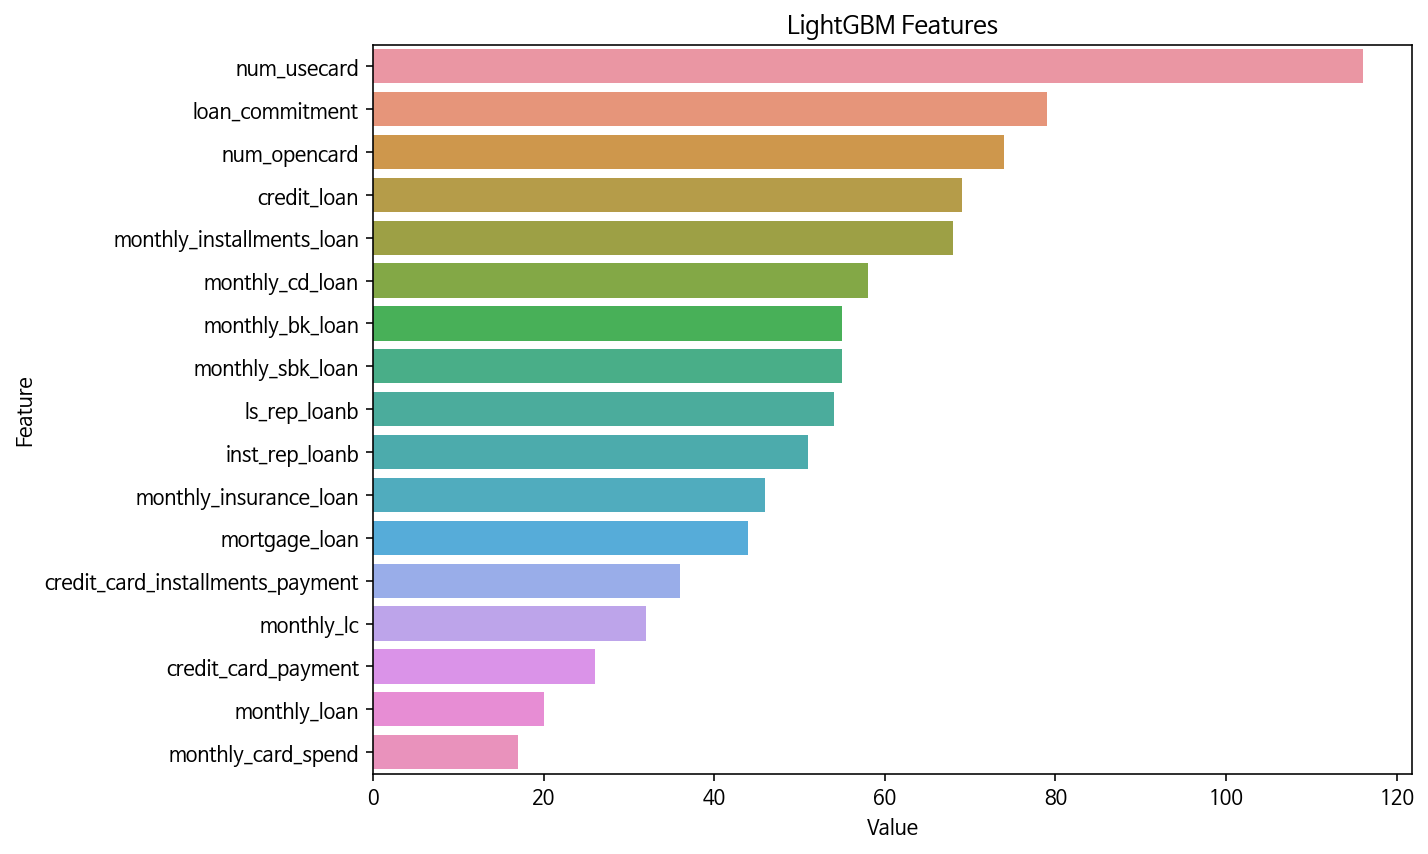

Weight,Feature
1.0934 ± 0.0694,num_usecard
0.2794 ± 0.0323,num_opencard
0.1837 ± 0.0145,monthly_cd_loan
0.1386 ± 0.0132,monthly_installments_loan
0.1319 ± 0.0112,ls_rep_loanb
0.1301 ± 0.0134,monthly_bk_loan
0.0671 ± 0.0071,monthly_sbk_loan
0.0483 ± 0.0041,inst_rep_loanb
0.0214 ± 0.0013,monthly_lc
0.0189 ± 0.0009,credit_loan


In [21]:
from lightgbm import LGBMRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 10,
    'objective': 'regression_l2', 
    'metric': ['mae', 'mse'],
    'verbose': -1,
}

lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    eval_metric=['mae', 'mse'],
    verbose=10,
)

feature_importance = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

perm = PermutationImportance(lgbm_model).fit(val_split[cols_to_fit], val_split[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

### [3-2] XGBRegressor

[16:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:560.632
[10]	validation_0-rmse:18.5147
[20]	validation_0-rmse:8.25458
[30]	validation_0-rmse:7.17874
[40]	validation_0-rmse:6.36091
[50]	validation_0-rmse:5.9082
[60]	validation_0-rmse:5.35105
[70]	validation_0-rmse:5.09697
[80]	validation_0-rmse:4.86853
[90]	validation_0-rmse:4.73492
[99]	validation_0-rmse:4.60725


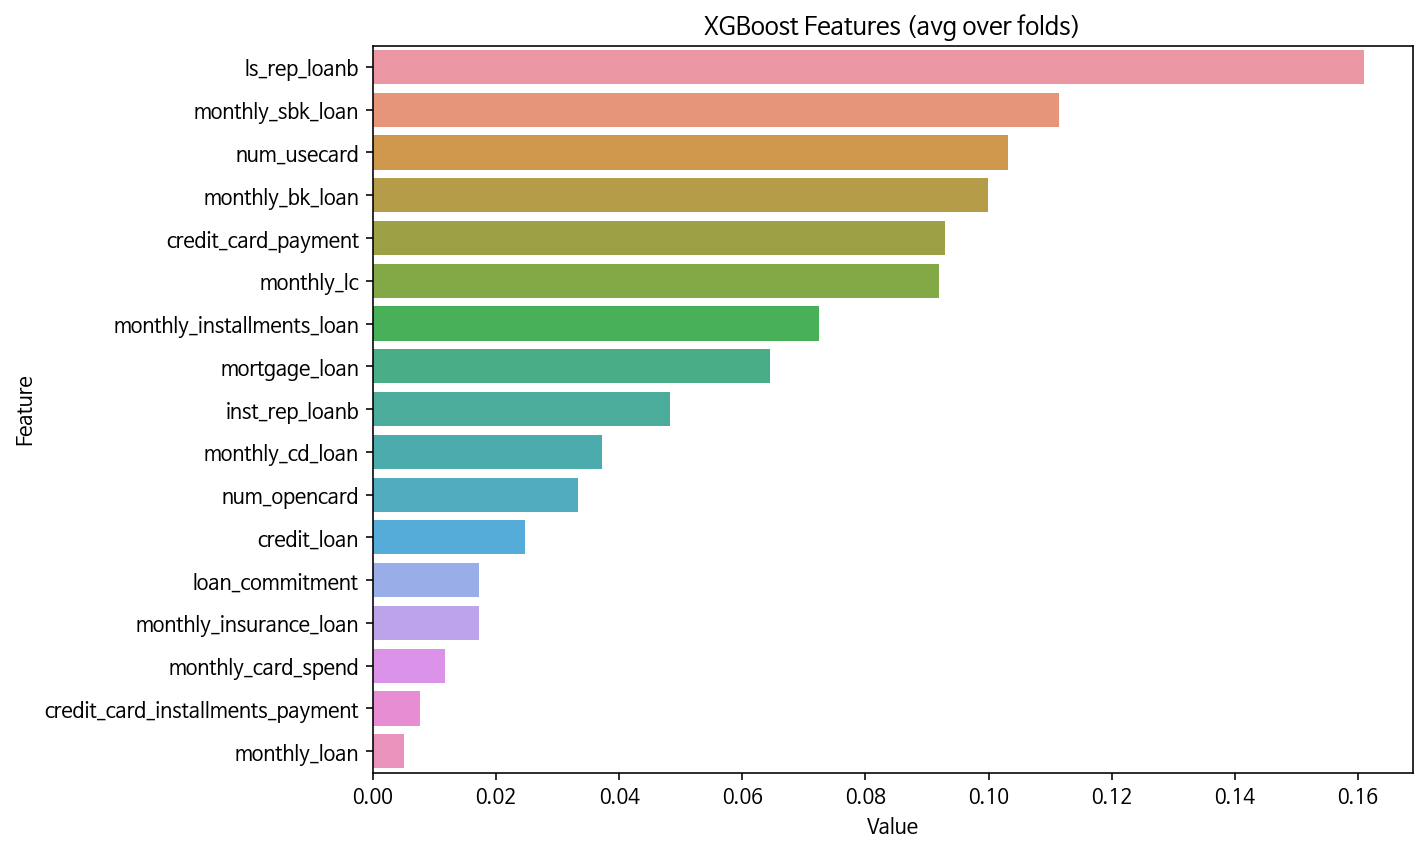

Weight,Feature
1.8644 ± 0.1500,num_usecard
0.2265 ± 0.0102,monthly_installments_loan
0.1848 ± 0.0136,credit_card_payment
0.1308 ± 0.0062,monthly_cd_loan
0.1107 ± 0.0126,monthly_sbk_loan
0.1010 ± 0.0048,num_opencard
0.0671 ± 0.0028,monthly_bk_loan
0.0534 ± 0.0060,ls_rep_loanb
0.0501 ± 0.0029,monthly_lc
0.0462 ± 0.0015,mortgage_loan


In [22]:
from xgboost import XGBRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 10,
    'verbose': -1,
}

xgb_model = XGBRegressor(**params)
xgb_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    verbose=10,
)

feature_importance = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

perm = PermutationImportance(xgb_model).fit(val_split[cols_to_fit], val_split[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

학습/검증 데이터를 분배하고, 모델 파라미터를 여러가지로 조정해본 결과,   
공통적으로 중요하게 여겨지는 변수는
* num_usecard
* monthly_installments_loan
* monthly_cd_loan


공통적으로 중요치 않게 여겨지는 변수는
* monthly_loan

따라서 사용 카드 갯수가 신용도 예측에 가장 큰 영향을 준 것을 알 수 있다.

## [4] 분석 : SHAP 중요도 분석
---
위의 중요도로는 변수가 얼마나 영향을 주는지만 알 수 있을 뿐,   
신용도를 높이거나 낮추는 데에는 어떤 영향이 있는지 알 수 없다. 

SHAP를 사용해 변수의 값이 높을/낮을 때 신용도가 올라가는지 내려가는지를 보인다.

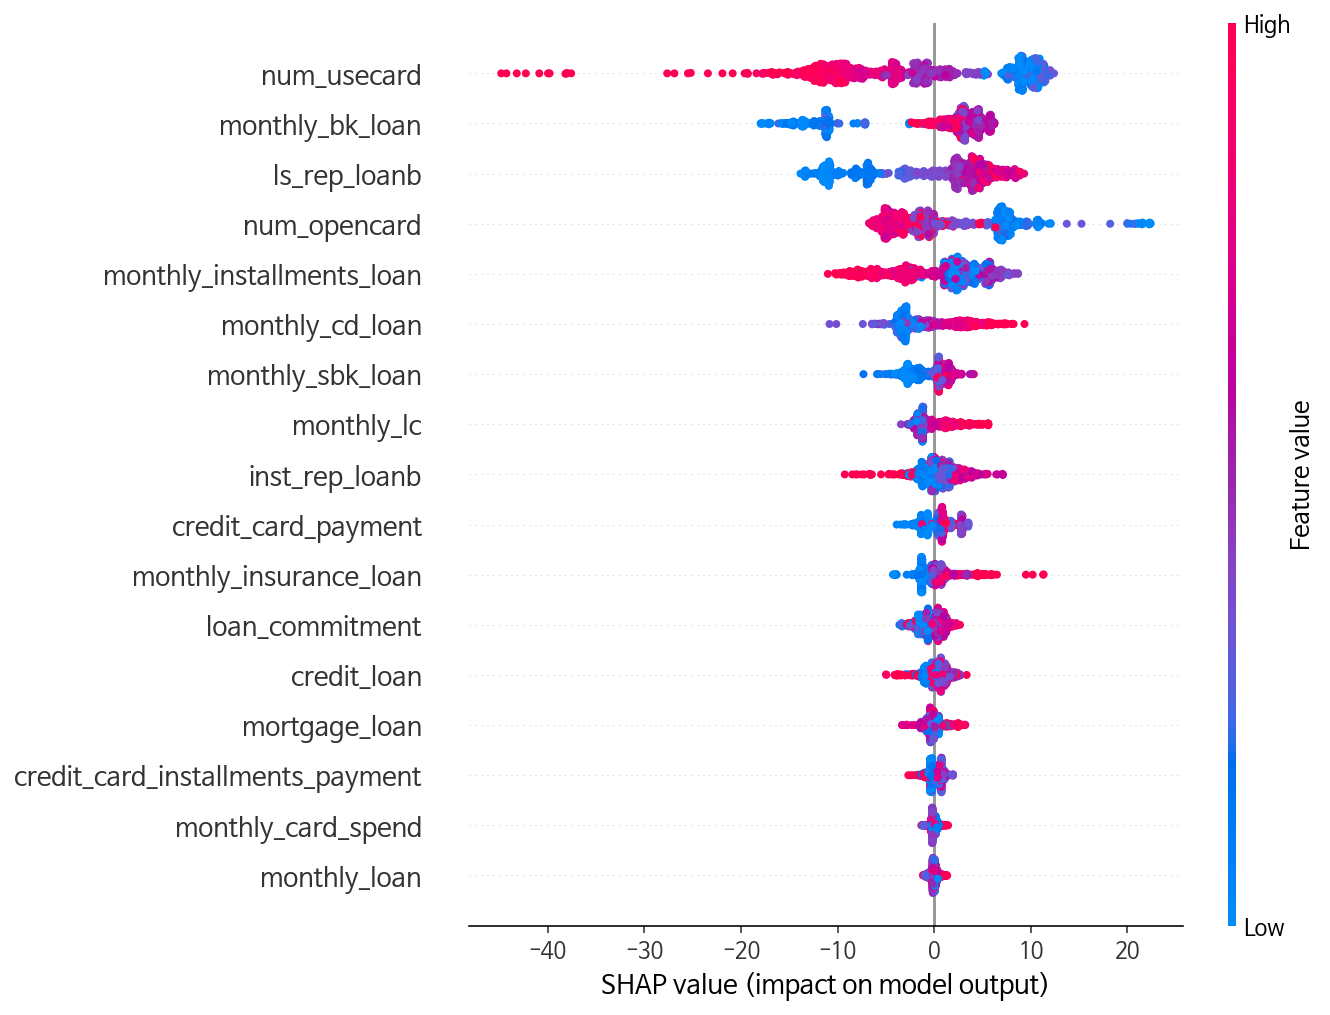

In [23]:
# lightBGM 모델을 해석하기 위해 Shap Value로 구현 및 시각화
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])

# 빨간색 : target ( avg_score ) 에 대해 양의 영향력
# 파란색 : target ( avg_score ) 에 대해 음의 영향력

상단 그림인 lightBGM 모델에 대한 SHAP value 해석
- num_usecard : 변수값이 낮을수록, 신용 등급이 높은 경향
- num_usecard : 변수값이 낮을수록, 신용 등급이 높은 경향

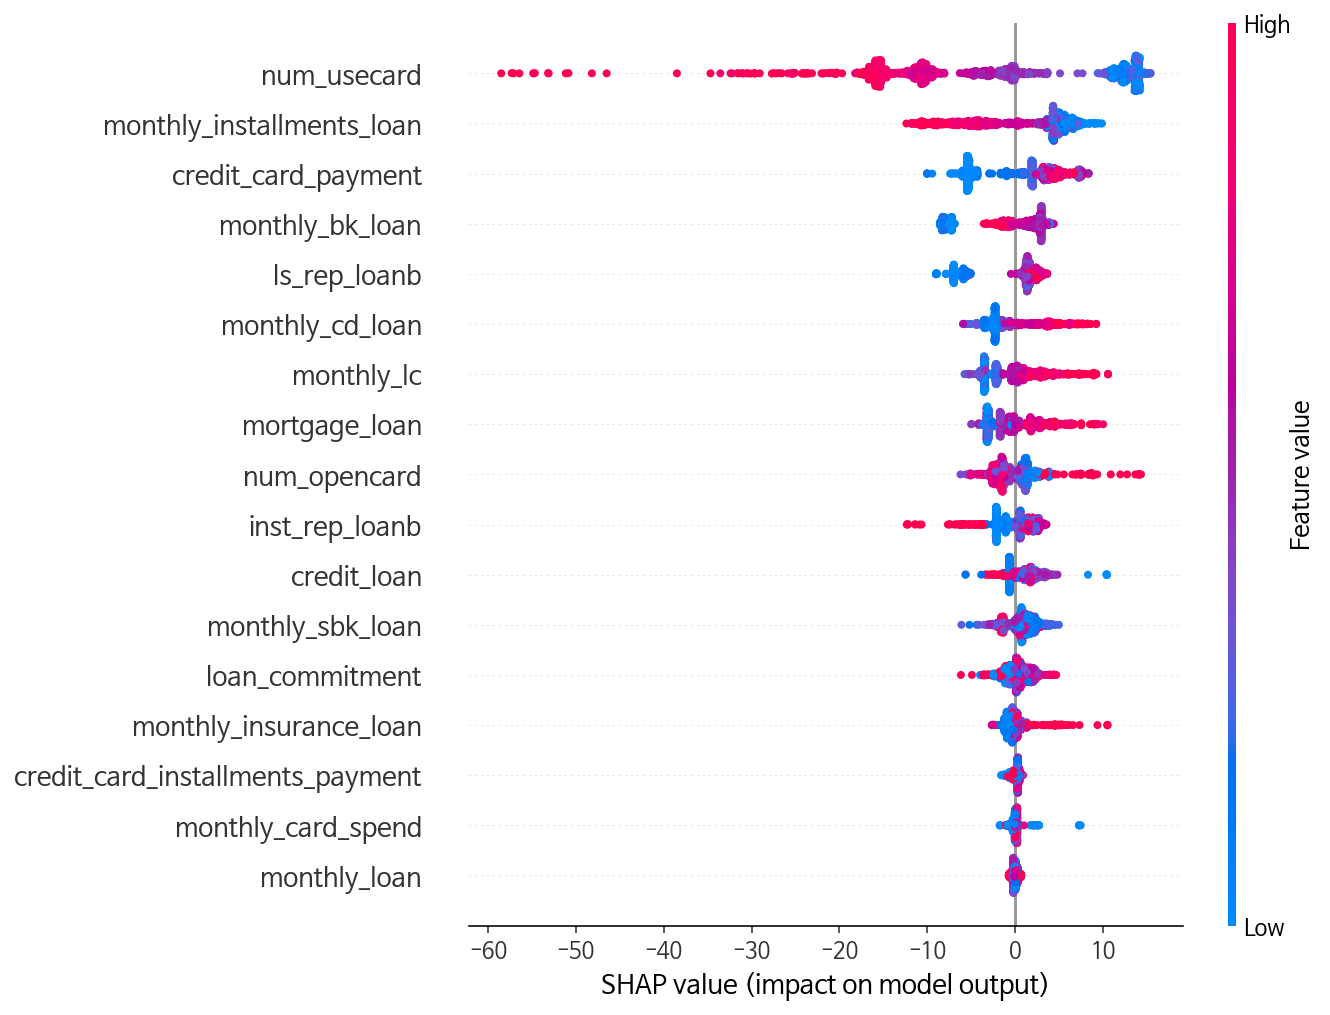

In [24]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])

SHAP 분석에 따르면 사용 카드가 많을수록 신용도가 낮고 적을수록 높다고 예측한다.   
하지만 사용카드의 수가 너무 큰 영향을 끼치는 것으로 보이기에 '*num_usecard*'와 '*num_opencard*'를 제외하고 다시 학습을 진행한다.

[16:25:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


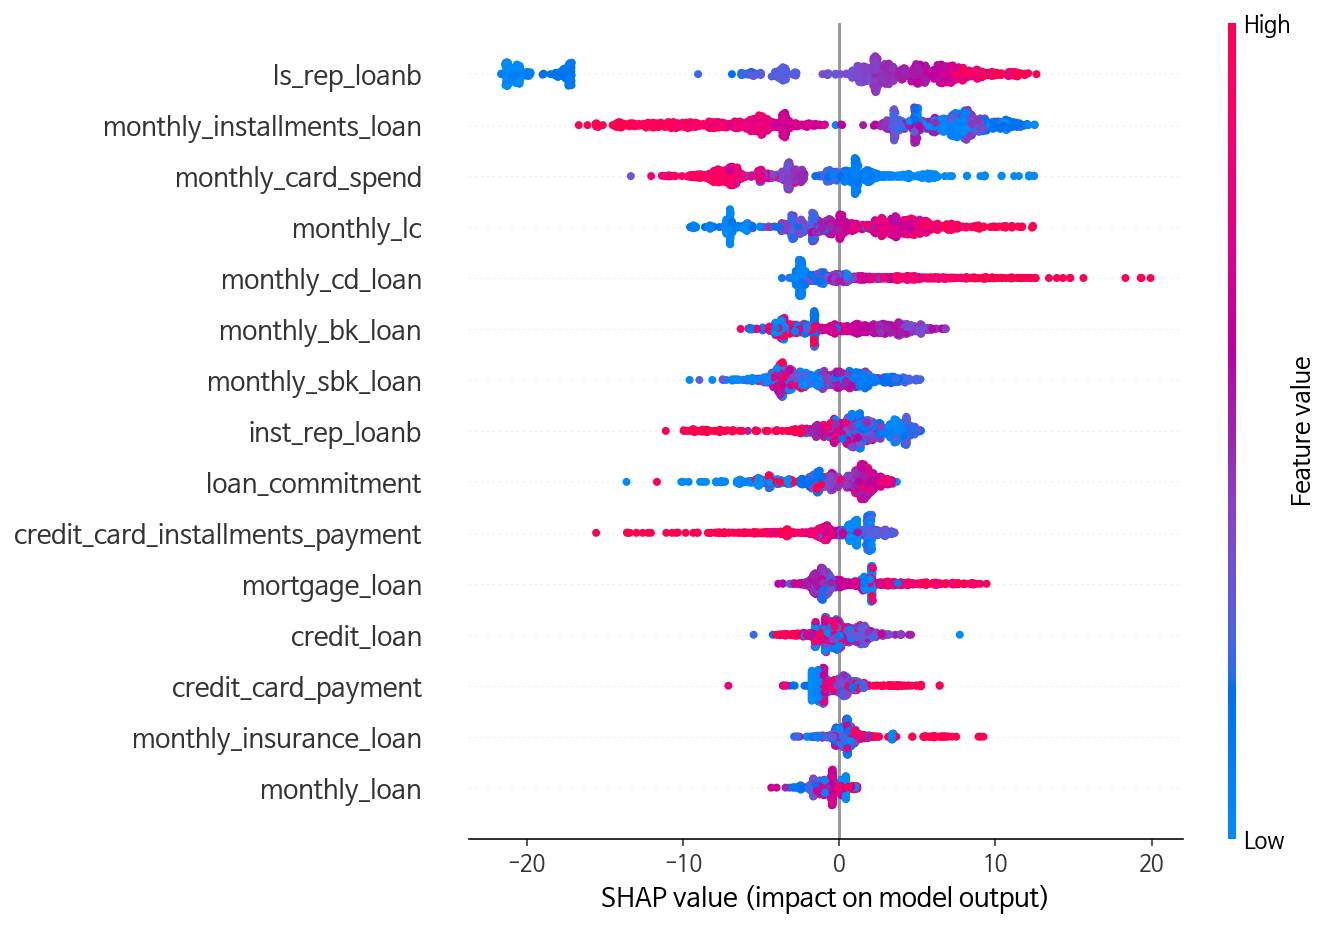

In [25]:
target = 'avg_score'
cols_to_drop = ['pop_cd','city','ages', 'sex', 'year_month', 'population','avg_rat', target]+['num_usecard', 'num_opencard']
cols_to_fit = [col for col in train.columns if col not in cols_to_drop]
train_split, val_split = train_test_split(train, test_size=0.3)

xgb_model = XGBRegressor(**params)
xgb_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    verbose=0,
)

feature_importance = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])

## [5] 결론

나머지 변수들을 토대로 신용도를 추정하자면 비례관계가 불확실한(값의 높고 낮음이 혼재된) 변수를 제외하면

* 할부금융 대출이 적을수록
* 일시상환대출 잔여금액이 많을수록
* 월간 카드 사용량이 적을수록
* 월간 카드 대출량이 많을수록
* 신용카드 사용금액이 적을수록
* 대출금액 총합이 많을수록

신용도가 높게 추정된다.


